# Electric Motor Speed Prediction

- ambient = Ambient temperature as measured by a thermal sensor located closely to the stator.
- coolant = Coolant temperature. The motor is water cooled. Measurement is taken at outflow.
- u_d = Voltage d-component
- u_q = Voltage q-component
- motor_speed = Motor speed
- torque= Torque induced by current.
- i_d = Current d-component
- i_q = Current q-component
- pm = Permanent Magnet surface temperature representing the rotor temperature. This was measured with an infrared thermography unit.
- stator_yoke = Stator yoke temperature measured with a thermal sensor.
- stator_tooth = Stator tooth temperature measured with a thermal sensor.
- stator_winding = Stator winding temperature measured with a thermal sensor.
- profile_id = Each measurement session has a unique ID. Make sure not to try to estimate from one session onto the other as they are strongly independent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from warnings import filterwarnings
filterwarnings('ignore')
df=pd.read_csv('pmsm_temperature_data.csv',usecols=[0,1,2,3,4,5,6,7,8,9,10,11])
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145


In [2]:
df.shape

(998070, 12)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 12 columns):
ambient           998070 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               998070 non-null float64
pm                998070 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
dtypes: float64(12)
memory usage: 91.4 MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ambient,998070.0,-0.003905,0.993127,-8.573954,-0.599385,0.266157,0.686675,2.967117
coolant,998070.0,0.004723,1.002423,-1.429349,-1.037925,-0.177187,0.650709,2.649032
u_d,998070.0,0.004780,0.997878,-1.655373,-0.826359,0.267542,0.358491,2.274734
u_q,998070.0,-0.005690,1.002330,-1.861463,-0.927390,-0.099818,0.852625,1.793498
motor_speed,998070.0,-0.006336,1.001229,-1.371529,-0.951892,-0.140246,0.853584,2.024164
torque,998070.0,-0.003333,0.997907,-3.345953,-0.266917,-0.187246,0.547171,3.016971
i_d,998070.0,0.006043,0.998994,-3.245874,-0.756296,0.213935,1.013975,1.060937
i_q,998070.0,-0.003194,0.997912,-3.341639,-0.257269,-0.190076,0.499260,2.914185
pm,998070.0,-0.004396,0.995686,-2.631991,-0.672308,0.094367,0.680691,2.917456
stator_yoke,998070.0,0.000609,1.001049,-1.834688,-0.747265,-0.057226,0.697344,2.449158


In [5]:
df.isnull().sum()

ambient           0
coolant           0
u_d               0
u_q               0
motor_speed       0
torque            0
i_d               0
i_q               0
pm                0
stator_yoke       0
stator_tooth      0
stator_winding    0
dtype: int64

In [6]:
df.skew()

ambient          -0.848914
coolant           0.628247
u_d               0.194644
u_q               0.199885
motor_speed       0.333305
torque           -0.042660
i_d              -0.622578
i_q              -0.075705
pm               -0.232903
stator_yoke       0.257297
stator_tooth     -0.061533
stator_winding   -0.028055
dtype: float64

In [7]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

ambient           1.286061
coolant           1.688634
u_d               1.184850
u_q               1.780015
motor_speed       1.805475
torque            0.814088
i_d               1.770271
i_q               0.756529
pm                1.352999
stator_yoke       1.444610
stator_tooth      1.534190
stator_winding    1.451282
dtype: float64


(814996, 12)

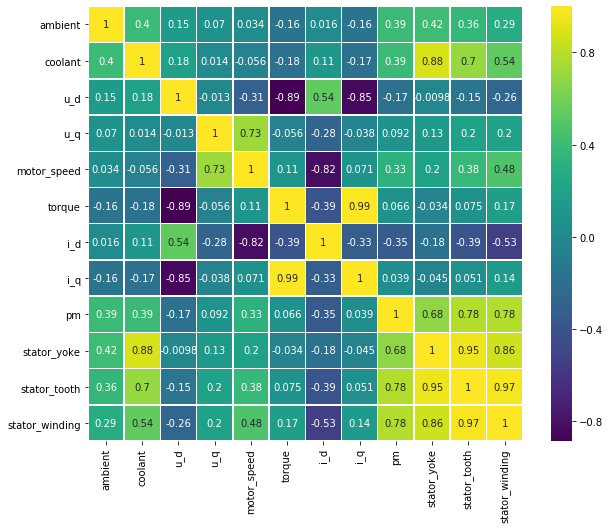

In [8]:
plt.figure(figsize = (10,8))
sns.heatmap(df.corr(), annot=True, linewidths=.5,square=True,cmap = 'viridis');

In [9]:
name = []
score = []
rmse = []

In [10]:
X = df.drop('motor_speed',axis=1)
y = df['motor_speed']

In [12]:
X.head()

,ambient,coolant,u_d,u_q,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145


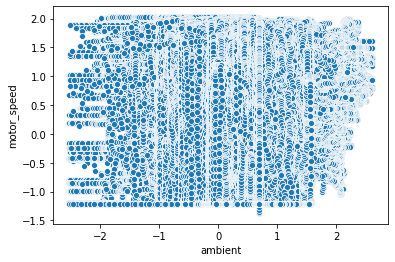

In [13]:
sns.scatterplot(x=X['ambient'],y=y);

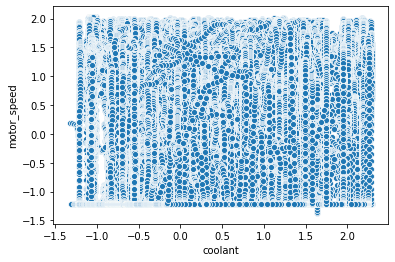

In [14]:
sns.scatterplot(x=X['coolant'],y=y);

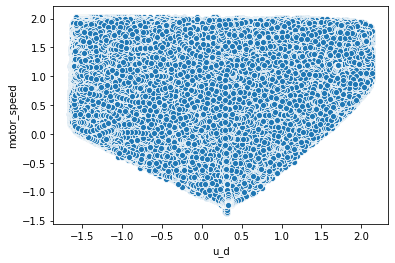

In [15]:
sns.scatterplot(x=X['u_d'],y=y);

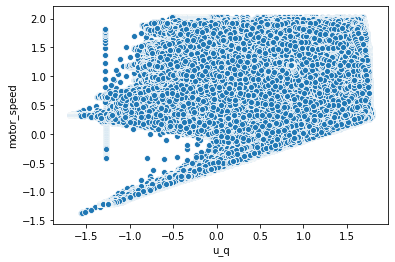

In [16]:
sns.scatterplot(x=X['u_q'],y=y);

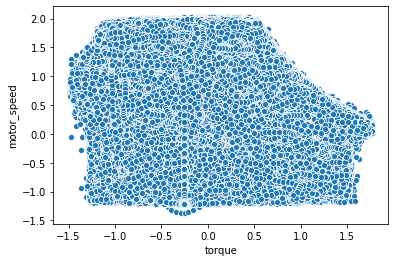

In [17]:
sns.scatterplot(x=X['torque'],y=y);

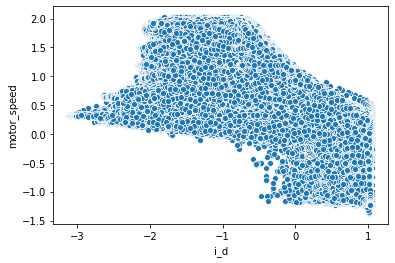

In [18]:
sns.scatterplot(x=X['i_d'],y=y);

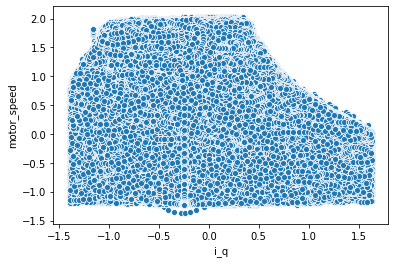

In [19]:
sns.scatterplot(x=X['i_q'],y=y);

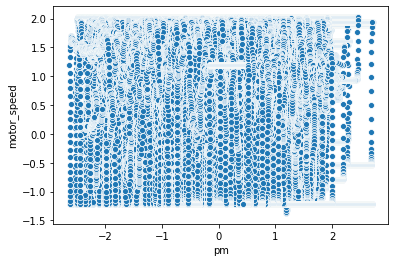

In [20]:
sns.scatterplot(x=X['pm'],y=y);

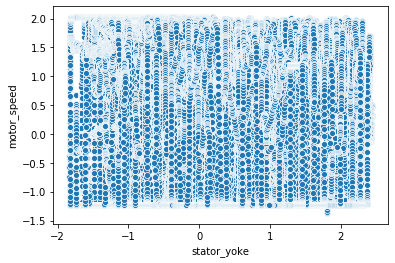

In [21]:
sns.scatterplot(x=X['stator_yoke'],y=y);

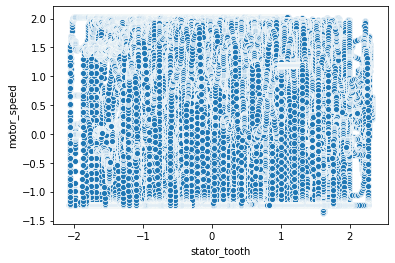

In [22]:
sns.scatterplot(x=X['stator_tooth'],y=y);

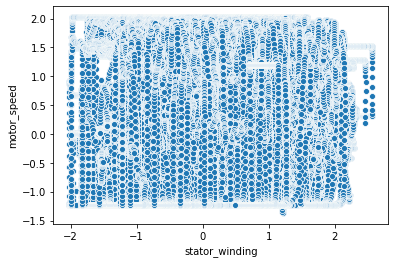

In [23]:
sns.scatterplot(x=X['stator_winding'],y=y);

In [24]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25, random_state=1)

## Multiple Linear Regression

In [25]:
X=sm.add_constant(X_train)

lm=sm.OLS(y_train,X_train)
model=lm.fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            motor_speed   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                          1.802e+06
Date:                Thu, 13 Feb 2020   Prob (F-statistic):                        0.00
Time:                        11:07:20   Log-Likelihood:                      1.7082e+05
No. Observations:              611247   AIC:                                 -3.416e+05
Df Residuals:                  611236   BIC:                                 -3.415e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
ambient           -0.0154      0.000    -47.173      0.000      -0.016      -0.015
coolant            0.2301      0.001    153.438      0.000       0.227       0.233
u_d               -0.4315      0.001   -546.355      0.000      -0.433      -0.430
u_q                0.4752      0.000   1621.517      0.000       0.475       0.476
torque            -2.2549      0.005   -416.056      0.000      -2.266      -2.244
i_d               -0.7568      0.000  -1616.236      0.000      -0.758      -0.756
i_q                1.5254      0.005    321.238      0.000       1.516       1.535
pm                 0.0748      0.000    154.445      0.000       0.074       0.076
stator_yoke       -0.7320      0.005   -156.745      0.000      -0.741      -0.723
stator_tooth       0.8283      0.006    129.260      0.000       0.816       0.841
stator_winding    -0.3543      0.003   -105.825      0.000      -0.361      -0.348
==============================================================================
Omnibus:                   327131.283   Durbin-Watson:                   1.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         31579109.854
Skew:                           1.668   Prob(JB):                         0.00
Kurtosis:                      38.054   Cond. No.                         74.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
#Root Mean Squared Error for Train
RMSE=np.sqrt(mean_squared_error(y_train,model.predict(X_train)))
RMSE

0.1829757885966674

In [27]:
model = LinearRegression().fit(X_train,y_train)
cvs=cross_val_score(model, X_test, y_test, cv=10, scoring='r2').mean() #verified score value for test model
print('Verified R2 value for Testing Model: ' + str(cvs))

Verified R2 value for Testing Model: 0.9780170141879247


In [28]:
name.append('Multiple Linear Regression')
score.append(cvs)
rmse.append(RMSE)

## Random Tree Regressor

In [29]:
rfr = RandomForestRegressor().fit(X_train,y_train)
y_pred = rfr.predict(X_test)

In [30]:
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE:  0.013211028250873991


In [31]:
print('Random Forest Regressor:' ,rfr.score(X_test,y_test))

Random Forest Regressor: 0.9998438122091262


In [32]:
name.append('Random Forest Regression')
score.append(rfr.score(X_test,y_test))
rmse.append(np.sqrt(mean_squared_error(y_test,y_pred)))

## KNN Regressor

In [33]:
knn_model=KNeighborsRegressor().fit(X_train, y_train)
y_pred=knn_model.predict(X_test)

In [34]:
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 0.03164420025603104


In [35]:
print('KNN Regressor:' ,knn_model.score(X_test,y_test))

KNN Regressor: 0.9991038884227896


In [36]:
name.append('KNN Regression')
score.append(knn_model.score(X_test,y_test))
rmse.append(np.sqrt(mean_squared_error(y_test,y_pred)))

## Decision Tree Regressor

In [37]:
dtr = DecisionTreeRegressor().fit(X_train,y_train)
y_pred = dtr.predict(X_test)

In [38]:
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE:  0.018928645902547683


In [39]:
print('Decision Tree Regressor:' ,dtr.score(X_test,y_test))

Decision Tree Regressor: 0.9996793635188477


In [40]:
name.append('Decision Tree Regression')
score.append(dtr.score(X_test,y_test))
rmse.append(np.sqrt(mean_squared_error(y_test,y_pred)))

## Extra Tree Regressor 

In [41]:
etr = ExtraTreesRegressor().fit(X_train,y_train)
y_pred = etr.predict(X_test)

In [42]:
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE:  0.011319729760251631


In [43]:
print('Extra Tree Regressor:' ,etr.score(X_test,y_test))

Extra Tree Regressor: 0.999885331017845


In [44]:
name.append('Extra Tree Regression')
score.append(etr.score(X_test,y_test))
rmse.append(np.sqrt(mean_squared_error(y_test,y_pred)))

## Bagging Regressor

In [45]:
br = BaggingRegressor().fit(X_train,y_train)
y_pred = br.predict(X_test)

In [46]:
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE:  0.012806760577705821


In [47]:
print('Bagging Regressor:' ,dtr.score(X_test,y_test))

Bagging Regressor: 0.9996793635188477


In [48]:
name.append('Bagging Regression')
score.append(br.score(X_test,y_test))
rmse.append(np.sqrt(mean_squared_error(y_test,y_pred)))

## Polynomial Regression

In [49]:
quad = PolynomialFeatures(degree = 2)
x_quad = quad.fit_transform(X_train)

X_train,X_test,y_train,y_test = train_test_split(x_quad,y_train, random_state = 1)

plr = LinearRegression().fit(X_train,y_train)

Y_train_pred = plr.predict(X_train)
Y_test_pred = plr.predict(X_test)

print('Polynomial Linear Regression:' ,plr.score(X_test,y_test))

Polynomial Linear Regression: 0.9983652714190635


In [50]:
np.sqrt(mean_squared_error(y_test,Y_test_pred))

0.04266750590741564

In [51]:
name.append('Polynomial Regression')
score.append(plr.score(X_test,y_test))
rmse.append(np.sqrt(mean_squared_error(y_test,Y_test_pred)))

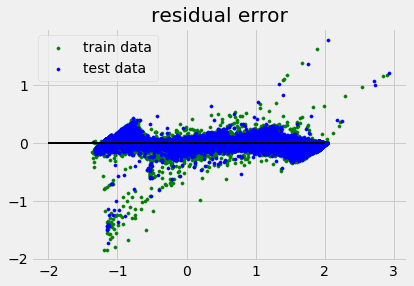

In [52]:
plt.style.use('fivethirtyeight')

#plotting residual errors in training data
plt.scatter(plr.predict(X_train),plr.predict(X_train)-y_train, 
            color="green", s=10, label="train data");

#plotting residual errors in test data
plt.scatter(plr.predict(X_test),plr.predict(X_test)-y_test, 
            color="blue", s=10, label="test data");

#plot line for zero residual error
plt.hlines(y=0,xmin=-2, xmax=2, linewidth=2)

#plot title
plt.title("residual error")

plt.legend(loc=0)
plt.show()

In [61]:
df = pd.DataFrame(score,index=name,columns=['Score'])

In [62]:
df['RMSE'] = rmse

In [63]:
df = df.reset_index()

In [64]:
df.columns

Index(['index', 'Score', 'RMSE'], dtype='object')

In [65]:
df['Model'] = df['index']

In [66]:
df.drop('index',axis=1,inplace=True)
df.head()

,Score,RMSE,Model
0,0.978017,0.182976,Multiple Linear Regression
1,0.999844,0.013211,Random Forest Regression
2,0.999104,0.031644,KNN Regression
3,0.999679,0.018929,Decision Tree Regression
4,0.999885,0.011320,Extra Tree Regression


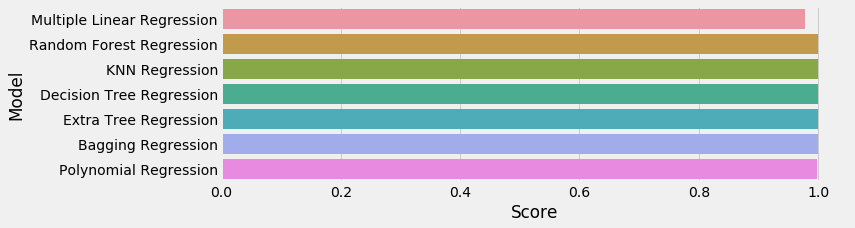

In [68]:
plt.figure(figsize= (10,3))
sns.barplot(df['Score'],df['Model']);

In [69]:
df

,Score,RMSE,Model
0,0.978017,0.182976,Multiple Linear Regression
1,0.999844,0.013211,Random Forest Regression
2,0.999104,0.031644,KNN Regression
3,0.999679,0.018929,Decision Tree Regression
4,0.999885,0.011320,Extra Tree Regression
5,0.999853,0.012807,Bagging Regression
6,0.998365,0.042668,Polynomial Regression
